In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam, AdamW, lr_scheduler
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import joblib
import numpy as np
import random as rd
import soundfile as sf


In [ ]:
!pip install pretty_midi
import pretty_midi

# The Dataset

In [ ]:
datas = joblib.load("/kaggle/input/holedbach/jsb1-li-train.pkl")
X = datas['X']
X = X.reshape(X.shape[0], 1, X.shape[1], X.shape[2]) # to 1 channel
X = X[:, :, 30:80, :]

datas_test = joblib.load("/kaggle/input/holedbach/jsb1-li-test.pkl")
X_test = datas_test['X']
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2]) # to 1 channel
X_test = X_test[:, :, 30:80, :]
from torch.utils.data import DataLoader

dataloader = DataLoader(X, batch_size=24, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

# The Diffusion Utils

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F


TIMESTEPS   = 1000
BETA_START  = 1e-4
BETA_END    = 0.02
betas       = torch.linspace(BETA_START, BETA_END, TIMESTEPS)
alphas      = 1.0 - betas
alphas_bar  = torch.cumprod(alphas, dim=0)  

# The Model

In [ ]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        half = self.dim // 2
        emb = math.log(10000) / (half - 1)
        emb = torch.exp(torch.arange(half, device=x.device) * -emb)
        emb = x[:, None] * emb[None, :]
        return torch.cat((emb.sin(), emb.cos()), dim=-1)

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.norm1 = nn.GroupNorm(8, out_ch)
        self.act = nn.SiLU()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)

    def forward(self, x, t_emb):
        start = x
        h = self.conv1(x)
        h = self.norm1(h)
        h = self.act(h)
        time = self.time_mlp(t_emb).view(x.size(0), -1, 1, 1)
        h = h + time
        h = self.conv2(h)
        return h #+ start

class UNet(nn.Module):
    def __init__(self, in_ch=1, time_emb_dim=256, c=1):
        super().__init__()

        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim)
        )

        self.init_conv = nn.Conv2d(in_ch, 64*c, 3, padding=1)

        self.down1 = ConvBlock(64*c, 128*c, time_emb_dim)
        self.pool1 = nn.Upsample(size=(25, 50))
        self.down2 = ConvBlock(128*c, 256*c, time_emb_dim)
        self.pool2 = nn.Upsample(size=(20, 25))
        self.down3 = ConvBlock(256*c, 512*c, time_emb_dim)
        self.pool3 = nn.Upsample(size=(16, 12))
        self.down4 = ConvBlock(512*c, 512*c, time_emb_dim)
        self.pool4 = nn.Upsample(size=(8, 6))

        self.bottleneck = ConvBlock(512*c, 512*c, time_emb_dim)

        self.uptrans4 = nn.Upsample(size=(16, 12))
        self.up4 = ConvBlock(512*c + 512*c, 512*c, time_emb_dim)
        self.uptrans3 = nn.Upsample(size=(20, 25))
        self.up3 = ConvBlock(512*c + 512*c, 256*c, time_emb_dim)
        self.uptrans2 = nn.Upsample(size=(25, 50))
        self.up2 = ConvBlock(256*c + 256*c, 128*c, time_emb_dim)
        self.uptrans1 = nn.Upsample(size=(50, 100))
        self.up1 = ConvBlock(128*c + 128*c, 64*c, time_emb_dim)

        self.final_conv = nn.Conv2d(64*c, in_ch, 1)

    def forward(self, x, t):
        t_emb = self.time_mlp(t)
        
        x1 = self.init_conv(x)
        
        d1 = self.down1(x1, t_emb) 
        p1 = self.pool1(d1)
        d2 = self.down2(p1, t_emb) 
        p2 = self.pool2(d2)
        d3 = self.down3(p2, t_emb)
        p3 = self.pool3(d3)
        d4 = self.down4(p3, t_emb)
        p4 = self.pool4(d4)
        
        bn = self.bottleneck(p4, t_emb) + bn
        
        
        u4 = self.uptrans4(bn)
        u4 = torch.cat([u4, d4], dim=1)
        u4 = self.up4(u4, t_emb)
        
        u3 = self.uptrans3(u4)
        u3 = torch.cat([u3, d3], dim=1)
        u3 = self.up3(u3, t_emb)
        
        u2 = self.uptrans2(u3)
        u2 = torch.cat([u2, d2], dim=1)
        u2 = self.up2(u2, t_emb)
        
        u1 = self.uptrans1(u2)
        u1 = torch.cat([u1, d1], dim=1)
        u1 = self.up1(u1, t_emb)
        
        return torch.sigmoid(self.final_conv(u1))



In [164]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        half = self.dim // 2
        emb = math.log(10000) / (half - 1)
        emb = torch.exp(torch.arange(half, device=x.device) * -emb)
        emb = x[:, None] * emb[None, :]
        return torch.cat((emb.sin(), emb.cos()), dim=-1)

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.norm1 = nn.GroupNorm(8, out_ch)
        self.act = nn.SiLU()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)

    def forward(self, x, t_emb):
        h = self.conv1(x)
        h = self.norm1(h)
        h = self.act(h)
        time = self.time_mlp(t_emb).view(x.size(0), -1, 1, 1)
        h = h + time
        h = self.conv2(h)
        return h

class SelfAttention2d(nn.Module):
    def __init__(self, channels, num_heads=8):
        super().__init__()
        assert channels % num_heads == 0, "channels must be divisible by num_heads"
        self.channels = channels
        self.num_heads = num_heads

        self.attn = nn.MultiheadAttention(embed_dim=channels, num_heads=num_heads, batch_first=True)
        self.norm = nn.LayerNorm(channels)

    def forward(self, x):
        b, c, h, w = x.shape

        seq_len = h * w
        x_flat = x.view(b, c, seq_len).permute(0, 2, 1)  # (B, S, C)
        attn_out, _ = self.attn(x_flat, x_flat, x_flat)
        x_res = self.norm(attn_out + x_flat)

        out = x_res.permute(0, 2, 1).view(b, c, h, w)
        return out

class UNet(nn.Module):
    def __init__(self, in_ch=1, time_emb_dim=256, c=1, attn_heads=8):
        super().__init__()
        # time embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim)
        )

        self.notes_embedding = nn.Embedding(50, 1)

        self.init_conv = nn.Conv2d(in_ch, 64*c, 3, padding=1)
        self.down1 = ConvBlock(64*c, 128*c, time_emb_dim)
        self.pool1 = nn.Upsample(size=(25, 50), mode='bilinear', align_corners=False)
        self.down2 = ConvBlock(128*c, 256*c, time_emb_dim)
        self.pool2 = nn.Upsample(size=(20, 25), mode='bilinear', align_corners=False)
        self.down3 = ConvBlock(256*c, 512*c, time_emb_dim)
        self.pool3 = nn.Upsample(size=(16, 12), mode='bilinear', align_corners=False)
        self.down4 = ConvBlock(512*c, 512*c, time_emb_dim)
        self.pool4 = nn.Upsample(size=(8, 6), mode='bilinear', align_corners=False)

        self.bottleneck = ConvBlock(512*c, 512*c, time_emb_dim)
        self.attn_latent = SelfAttention2d(512*c, num_heads=attn_heads)
        self.attn_latent2 = SelfAttention2d(512*c, num_heads=attn_heads)


        self.uptrans4 = nn.Upsample(size=(16, 12), mode='bilinear', align_corners=False)
        self.up4 = ConvBlock(512*c + 512*c, 512*c, time_emb_dim)
        self.uptrans3 = nn.Upsample(size=(20, 25), mode='bilinear', align_corners=False)
        self.up3 = ConvBlock(512*c + 512*c, 256*c, time_emb_dim)
        self.uptrans2 = nn.Upsample(size=(25, 50), mode='bilinear', align_corners=False)
        self.up2 = ConvBlock(256*c + 256*c, 128*c, time_emb_dim)
        self.uptrans1 = nn.Upsample(size=(50, 100), mode='bilinear', align_corners=False)
        self.up1 = ConvBlock(128*c + 128*c, 64*c, time_emb_dim)
        self.final_conv = nn.Conv2d(64*c, in_ch, 1)

    def forward(self, x, t):
        #print(x.shape)
        notes_emb = self.notes_embedding(torch.arange(50).to(device))
        if False:
            plt.imshow(x[0, 0].cpu().numpy())
            plt.show()
        x += torch.sigmoid(notes_emb)*0.3
        if False:
            plt.imshow(x.detach()[0, 0].cpu().numpy())
            plt.show()

        
        t_emb = self.time_mlp(t)
        x1 = self.init_conv(x)
        d1 = self.down1(x1, t_emb)
        p1 = self.pool1(d1)
        d2 = self.down2(p1, t_emb)
        p2 = self.pool2(d2)
        d3 = self.down3(p2, t_emb)
        p3 = self.pool3(d3)
        d4 = self.down4(p3, t_emb)
        p4 = self.pool4(d4)

        bn = self.bottleneck(p4, t_emb)
        bn = self.attn_latent(bn) + bn
        bn = self.attn_latent2(bn) + bn

        u4 = self.uptrans4(bn)
        u4 = torch.cat([u4, d4], dim=1)
        u4 = self.up4(u4, t_emb)
        u3 = self.uptrans3(u4)
        u3 = torch.cat([u3, d3], dim=1)
        u3 = self.up3(u3, t_emb)
        u2 = self.uptrans2(u3)
        u2 = torch.cat([u2, d2], dim=1)
        u2 = self.up2(u2, t_emb)
        u1 = self.uptrans1(u2)
        u1 = torch.cat([u1, d1], dim=1)
        u1 = self.up1(u1, t_emb)
        return torch.sigmoid(self.final_conv(u1))



# Noiser
This add_noise function is a simple implementation of a forward diffusion process with a binomial kernel similar to what Lilac Atassi did in **Generating symbolic music using diffusion models**

The beta is directly assigned here without using a pre scheduled beta for simplicty

In [155]:
def add_noise(roll, t):
    beta = (t + 1) / TIMESTEPS
    p = roll * (1 - beta) + 0.03 * beta
    noisy = torch.bernoulli(p).float()
    return noisy

# Model & Train

The Model is a simple UNet with 4 downsampling, it can be made way more powerful, starting with self attention in the latent!

With the train as implemented now the model tries to restore the entire pianoroll from a random timestep t corrupted image, then the L1 loss is computed with the undestroyed "image"

In [171]:
model = UNet(in_ch=1, time_emb_dim=256, c=2)
model = model.to(device)
optimizer = Adam(model.parameters(), lr=0.0001)
total_params = sum(p.numel() for p in model.parameters())
criterion = nn.L1Loss()
print(f"Number of parameters: {total_params:_}")

Number of parameters: 110_159_923


0.055628821980037275 0.051493698886997244 tensor(0.0111, device='cuda:0', grad_fn=<MulBackward0>)


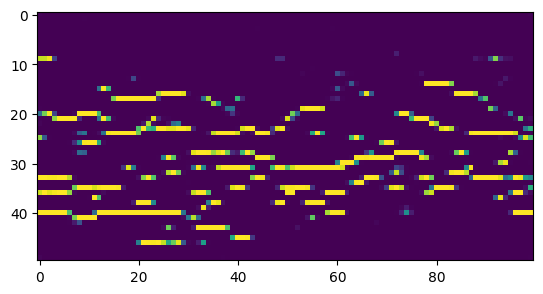

0.04942546395687472 0.04683034249513043 tensor(0.0018, device='cuda:0', grad_fn=<MulBackward0>)


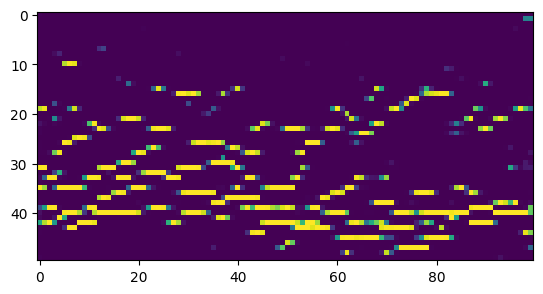

0.049683072514524425 0.04606097294103115 tensor(0.0004, device='cuda:0', grad_fn=<MulBackward0>)


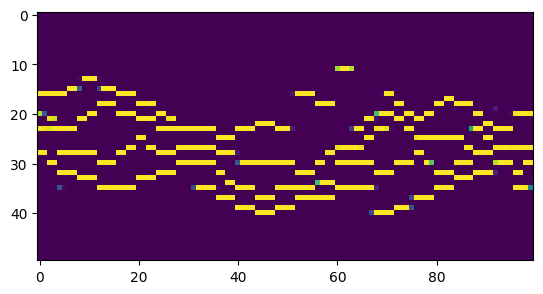

In [175]:
epochs = 3
for epoch in range(epochs):
    losses1 = []
    losses2 = []
    for i, batch in enumerate(dataloader):
        batch = batch.float().to(device)
        optimizer.zero_grad()
        t = rd.randint(0, TIMESTEPS-1)
        T = torch.full((batch.shape[0],), t).to(device)
        destroyed = add_noise(batch, t)
        
        """plt.imshow(batch[0, 0].cpu().numpy())
        plt.show()
        plt.imshow(destroyed[0, 0].cpu().numpy())
        plt.show()"""
        
        pred = model(destroyed, T)
        """plt.imshow(pred.detach().cpu().numpy()[0, 0])
        plt.show()"""
        
        loss1 = criterion(pred, batch) + (pred.mean() - batch.mean()).abs()
        loss2 = nn.L1Loss()(pred, batch)
        
        loss1.backward()
        optimizer.step()
        
        losses1.append(loss1.item())
        losses2.append(loss2.item())

    print(np.mean(losses1), np.mean(losses2), (pred.mean() - batch.mean()).abs()*2 )
    plt.imshow(pred.detach().cpu().numpy()[0, 0])
    plt.show()

In [ ]:
import gc
gc.collect()

torch.cuda.empty_cache()

del batch
del loss
# del model

# Here my vary basic Sampling (not sure its the best way)

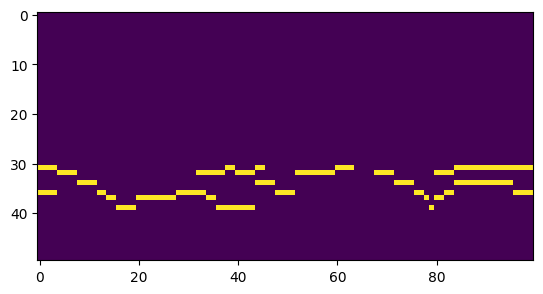

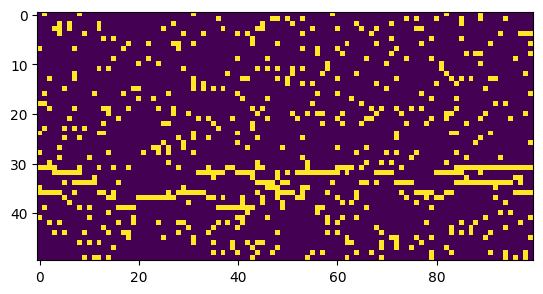

tensor(0.0800, device='cuda:0')


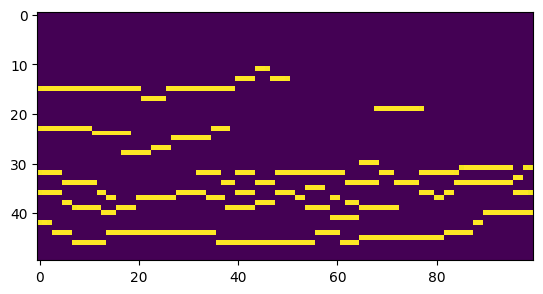

In [179]:
harmonize = True
if not harmonize:
    sample = torch.bernoulli(torch.ones((1, 1, 50, 100))/7).to(device)
plt.imshow(sample[0, 0].cpu().numpy())
plt.show()
if harmonize:
    noise = torch.bernoulli(torch.ones((1, 1, 50, 100))/10).to(device)
    sample[noise == 1] = 1
    plt.imshow(sample[0, 0].cpu().numpy())
    plt.show()
with torch.no_grad():
    for i in reversed(range(300)):
        sample = model(sample, torch.tensor([i]).to(device))
    print(sample.mean())
    sample[sample < 0.5] = 0
    plt.imshow(sample.cpu().numpy()[0, 0])

_sample = torch.zeros((128, 100))
_sample[30:80, :] = sample

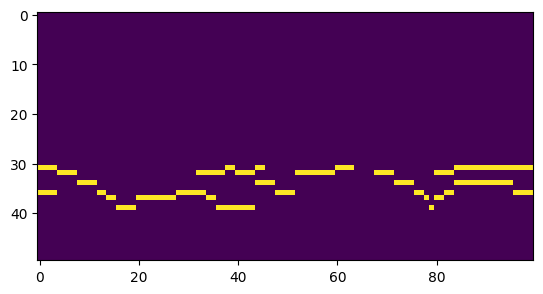

In [178]:
to_harmonize = X_test[2, 0].copy()
to_harmonize[0:30] = 0
plt.imshow(to_harmonize)
sample = torch.tensor(to_harmonize[None, None, :, :]).float().to(device)

In [92]:
def multi_hot_to_midi(piano_roll: np.ndarray, time_per_step: float = 0.2,
                      velocity: int = 100) -> pretty_midi.PrettyMIDI:
    print(piano_roll.shape)
    T, n_pitches = piano_roll.shape
    if n_pitches != 128:
        raise ValueError("The input piano roll must have 128 columns (for MIDI notes 0-127).")

    midi_obj = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=0)

    active_notes = {}

    for t in range(T):
        current_time = t * time_per_step
        current_frame = piano_roll[t]  # shape: (128,)

        for pitch in range(128):
            is_active = current_frame[pitch] > 0
            prev_active = piano_roll[t - 1][pitch] > 0 if t > 0 else False

            if is_active and not prev_active:
                active_notes[pitch] = current_time
            elif not is_active and prev_active:
                start_time = active_notes.pop(pitch, current_time)
                note = pretty_midi.Note(velocity=velocity, pitch=pitch, start=start_time, end=current_time)
                instrument.notes.append(note)

    final_time = T * time_per_step
    for pitch, start_time in active_notes.items():
        note = pretty_midi.Note(velocity=velocity, pitch=pitch, start=start_time, end=final_time)
        instrument.notes.append(note)

    midi_obj.instruments.append(instrument)
    return midi_obj

def midi_to_audio(midi_path, fs=44100, tempo=100, autoplay=False):
    pm = midi_path                                                

    wav = pm.synthesize(fs)                                          
    wav = wav / np.max(np.abs(wav))                                  
    return Audio(wav, rate=fs, autoplay=autoplay)   

import pretty_midi
import matplotlib.pyplot as plt
import numpy as np

def plot_midi_pianoroll(midi_path, fs=100):
    pm = midi_path
    
    piano_roll = pm.get_piano_roll(fs=fs)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(piano_roll, aspect='auto', origin='lower', cmap='gray_r', 
               extent=[0, piano_roll.shape[1] / fs, 0, 128])
    plt.xlabel('Time (s)')
    plt.ylabel('MIDI Pitch')
    plt.title('Piano Roll')
    plt.colorbar(label='Velocity')
    plt.tight_layout()
    plt.show()

(100, 128)


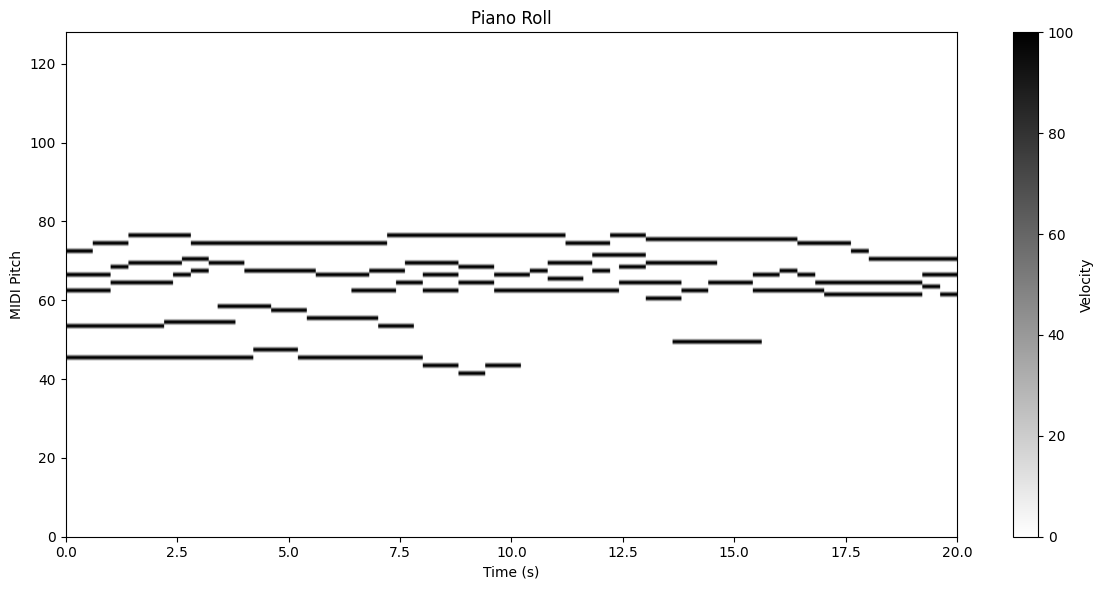

In [180]:
midi = multi_hot_to_midi(_sample.cpu().numpy().T)
plot_midi_pianoroll(midi)
from IPython.display import Audio
midi_to_audio(midi)

# Considerations
The results are promising, I know the generated midi aren't really musical, but we need to consider the dataset is very poor with just around 2600 examples, which are already augmented!
The VAE on the same dataset actually producer way better results, and this because the variation latent of just 32 dimensions costrict the model to understand the meaning of chords, progressions, and harmony; here however a simple UNet is uset, and i suppose it is not really understanding what's music.
I also hope that giving the model a variational latent and self attention (or maybe FiLM) it would be able to better understand whats music.

# A very cool thing
The hidden power this type of diffusion could have is to generate from non total noise example, which means it would maybe be to harmonize, or add voices (or remove them) from already existing piano rolls, which can be very cool from an artistic point of view. (Don't know tho if the model needs to see these example in the dataet or not, i hope that with a powerful model it can learn this ability alone!) 

### Latent Diffusion?
I for sure want to explore the idea of latent discrete diffusion, maybe in a VQ-VAE latent, but am not sure it would be better than a normal gaussian diffusion.
